In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class new_recon(nn.Module):
    def __init__(self):
        super(new_recon, self).__init__()

    def forward(self, output, labels, unconvs, inputs, lamda=1):
        loss = nn.CrossEntropyLoss()(output, labels)
        loss += lamda * nn.MSELoss()(inputs, unconvs)
        return loss


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.unconv1 = nn.ConvTranspose2d(16, 6, 5)
        self.unconv2 = nn.ConvTranspose2d(6, 3, 5)
    
    def forward(self, x):
        # print(x.shape)
        x, indices1 = self.pool(F.relu(self.conv1(x)))
        x, indices2 = self.pool(F.relu(self.conv2(x)))
        # calculating y
        y = torch.flatten(x, 1)
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = self.fc3(y)
        # calculating x
        x = self.unconv1(F.relu(self.unpool(x, indices2)))
        x = self.unconv2(F.relu(self.unpool(x, indices1)))
        return y, x

net = Net()


In [4]:
import torch.optim as optim

criterion = new_recon()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [20]:

def new_recon_loss(output, labels, unconvs, inputs, lamda = 1):
    loss = nn.CrossEntropyLoss()(output, labels)
    loss += lamda * nn.MSELoss()(inputs, unconvs)
    return loss


def trainModel(l):
    loss_list = []
    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            predicted_labels, recon_xs = net(inputs)
            loss = criterion(predicted_labels, labels, recon_xs, inputs, l)

            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                imshow(torchvision.utils.make_grid(recon_xs))
                imshow(torchvision.utils.make_grid(inputs))
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                


                running_loss = 0.0

    print('Finished Training')


In [7]:
#testing

def testModel():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            predicted_labels, recon_xs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(predicted_labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


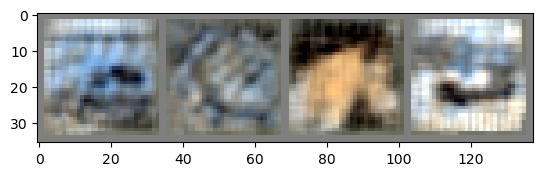

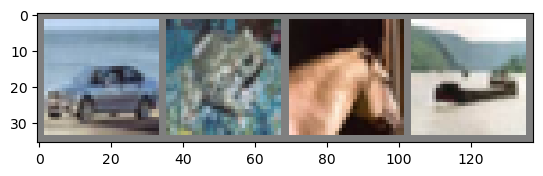

[1,  2000] loss: 1.793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


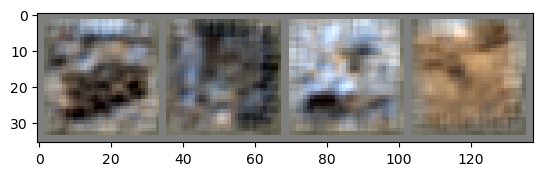

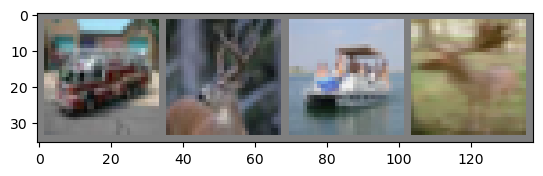

[1,  4000] loss: 1.771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


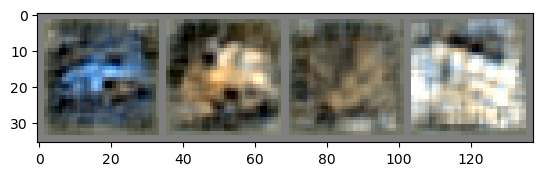

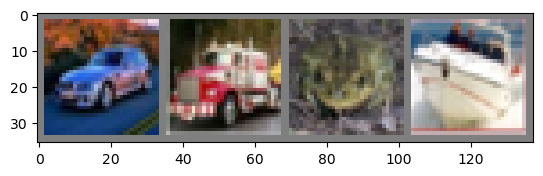

[1,  6000] loss: 1.820


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


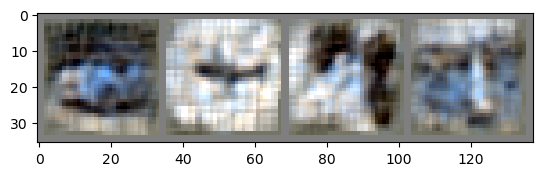

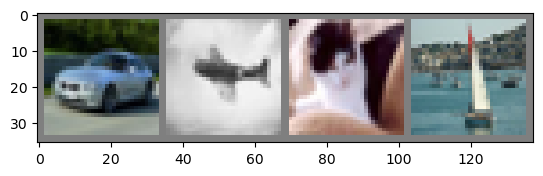

[1,  8000] loss: 1.812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


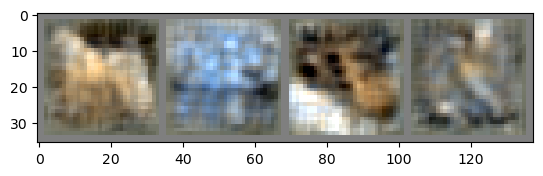

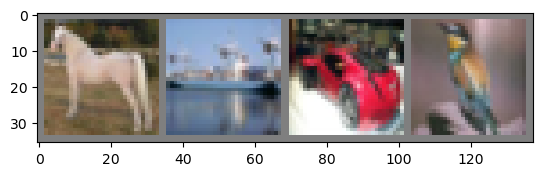

[1, 10000] loss: 1.819


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


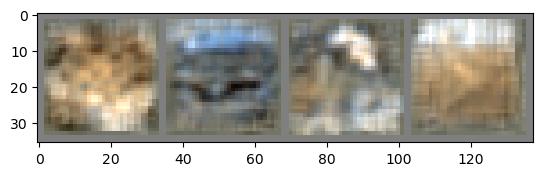

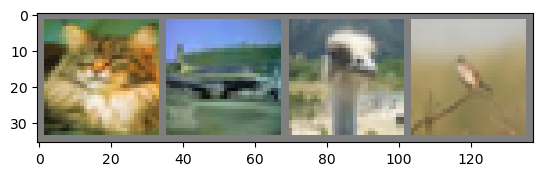

[1, 12000] loss: 1.820


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


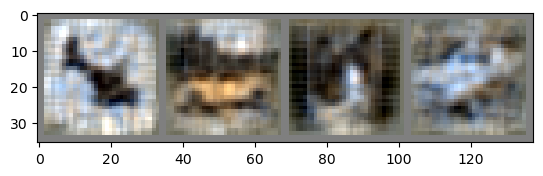

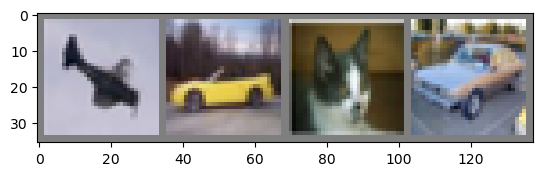

[2,  2000] loss: 1.753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


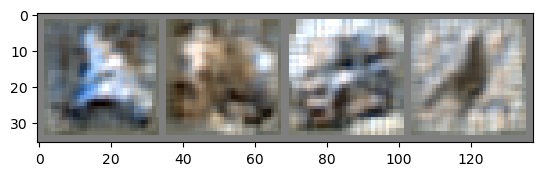

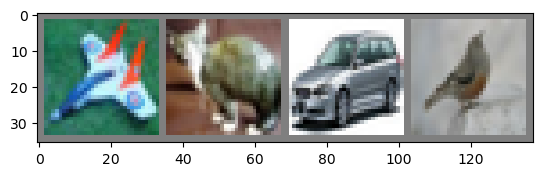

[2,  4000] loss: 1.749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


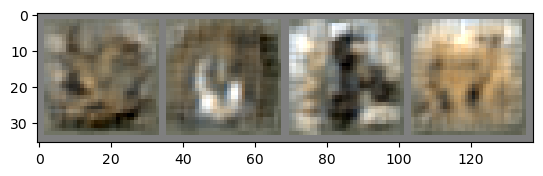

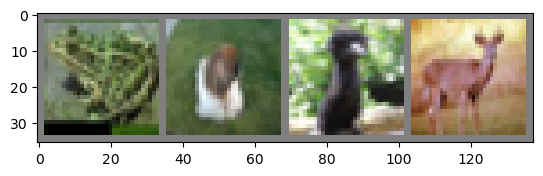

[2,  6000] loss: 1.774


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


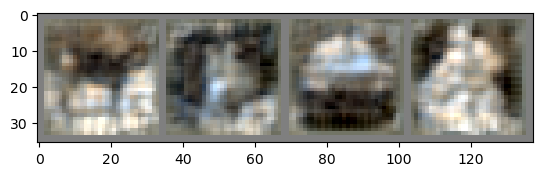

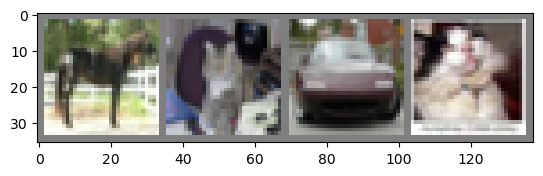

[2,  8000] loss: 1.766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


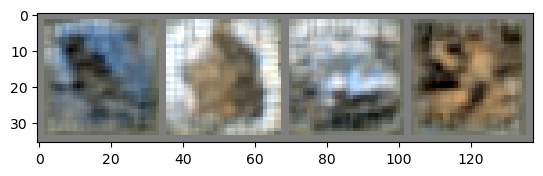

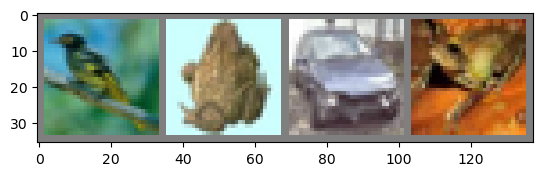

[2, 10000] loss: 1.791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


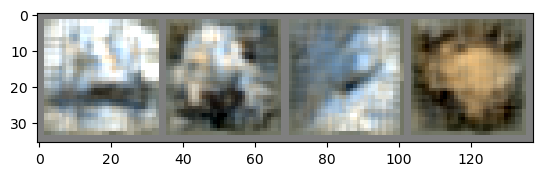

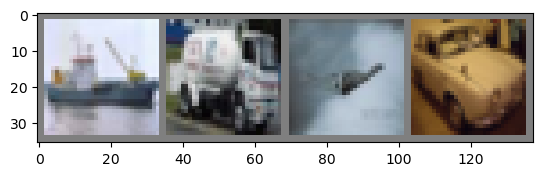

[2, 12000] loss: 1.765
Finished Training
Accuracy of the network on the 10000 test images: 58.46%


In [21]:
trainModel(l=10)
testModel()